In [1]:
import numpy as np
import sys
sys.path.append("/cluster/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams
from pathlib import Path

video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()

clip_names = np.array(
    [

        "1290-2023-01-31-13-22-58-3ef10981",
        "1002-2022-12-14-11-43-58-23e05b8c",
    ]
)


In [2]:
rec = video_loader(of_params)

In [ ]:
ts, images_left, images_right = rec._get_frames(clip_names[0], convert_to_gray=True)
blink_df = rec._load_gt_labels(clip_names[0])


In [157]:
ts.shape

(2604,)

105
163


In [47]:
of_params

OfParams(n_layers=1, layer_interval=0, average=False, img_shape=(64, 64), grid_size=10, step_size=5, window_size=11, stop_steps=3)

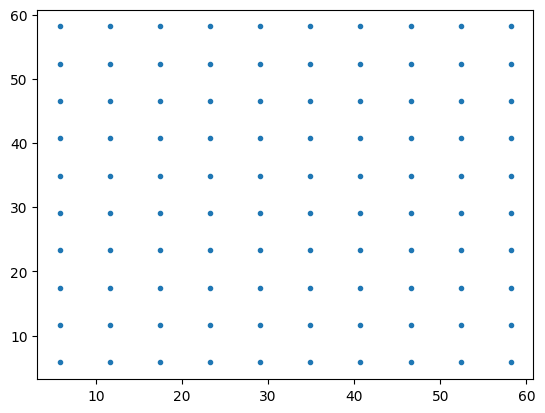

In [10]:
import matplotlib.pyplot as plt
plt.plot(grid[:, 0], grid[:, 1], ".")

In [ ]:
import scipy
a=scipy.interpolate.griddata(grid, feature_array[100, 0:100, 0], p_grid, method="nearest")

plt.imshow(p_grid, a)

In [33]:
x = np.linspace(0, 64, 65)

x = np.linspace(0, 64, 65, dtype=np.float32)[1:-1]
y = np.linspace(0, 64, 65, dtype=np.float32)[1:-1]
xx, yy = np.meshgrid(x, y)
p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [35]:
p_grid.shape

(3969, 2)

In [65]:
p

array([[ 1.,  1.],
       [ 2.,  1.],
       [ 3.,  1.],
       ...,
       [61., 63.],
       [62., 63.],
       [63., 63.]], dtype=float32)

In [210]:
from scipy.ndimage.interpolation import rotate

blink_ts = blink_df[blink_df["label"]=="onset"].iloc[6, :]["start_ts"]
blink_on_idx = int(np.where(ts == blink_ts)[0])
blink_ts = blink_df[blink_df["label"]=="offset"].iloc[5, :]["end_ts"]
blink_off_idx = int(np.where(ts == blink_ts)[0])

print(blink_on_idx)
print(blink_off_idx)

images = images_left[blink_on_idx-30:blink_off_idx+30, :, :]
images_left_rot = images_left

for ifr in range(0, images_left.shape[0]):
    images_left_rot[ifr, :, :] = rotate(images_left[ifr, :, :], 30, reshape=False)

feature_array, grid = rec._compute_optical_flow(of_params, images_left, images_right)
feature_array_rot, grid = rec._compute_optical_flow(of_params, images_left_rot, images_right)

feature_array = feature_array[blink_on_idx-30:blink_off_idx+30, :, :]

zz = np.zeros([63, 63, feature_array.shape[0]])
zz_rot = np.zeros([63, 63, feature_array.shape[0]])
frame_counter = 0
for iframe in range(0, feature_array.shape[0]):
    a=scipy.interpolate.griddata(grid, feature_array[iframe, 0:100, 1], p_grid, method="nearest")
    v=scipy.interpolate.griddata(grid, feature_array_rot[iframe, 0:100, 1], p_grid, method="nearest")
    count = 0
    for ix in range(0, 63):
        for iy in range(0, 63):
            zz[ix, iy, frame_counter] = a[count]
            zz_rot[ix, iy, frame_counter] = a[count]
            count += 1
    
    frame_counter += 1



/tmp/ipykernel_404570/493587117.py:1: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


1183
1235


In [208]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = images

fig, axs = plt.subplots(1,2)
im0 = axs[0].imshow(video[0,:,:,:], cmap='gray')
axs[0].axis("off")

im1 = axs[1].imshow(zz[:,:,0], vmin=-10, vmax=10)
axs[1].axis("off")

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:,:])
    im1.set_data(zz[:,:,0])

def animate(i):
    im0.set_data(video[i,:,:,:])
    im1.set_data(zz[:,:,i])
    return im0, im1

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [182]:
feature_array.shape

(72, 200, 2)

In [186]:
of_params

OfParams(n_layers=1, layer_interval=0, average=False, img_shape=(64, 64), grid_size=10, step_size=5, window_size=11, stop_steps=3)